# Capstone Project

In [31]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

## Prepare the neighborhood geographical info

### Script data from Wikipedia page

In [2]:
# script the html page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content,'lxml')

In [3]:
# get the PostalCode and save to a list
PostalCode = []
for tag in soup.find('table').find_all('b'):
    PostalCode.append(tag.get_text())

In [4]:
# get the Borough(Neighborhood) and save to a list
Borough = []
for tag in soup.find('table').find_all('span'):
    Borough.append(tag.get_text())

In [5]:
# create a dataframe and put the data above into it
df = pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])
df.PostalCode = PostalCode
df.Borough = Borough

In [6]:
# remove rows that contain unassigned boroughs
df = df[df.Borough != 'Not assigned'].reset_index(drop = True)

In [7]:
# clean the 'Borough' and 'Neighborhood' columns to the right format
for i in range(len(df)):
    l = df.Borough[i].split('(')
    df.Borough[i] = l[0]
    try:
        df.Neighborhood[i] = l[1]
    except:
        df.Neighborhood[i] = l[0]
    if df.Neighborhood[i][-1] == ')':
        df.Neighborhood[i] = df.Neighborhood[i][:-1]

In [8]:
for i in range(len(df)):
    if '/' in df.Borough[i]:
        df = df[df.index != i]
df = df.reset_index(drop = True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M9A,Etobicoke,Islington Avenue


In [9]:
df.shape

(102, 3)

### Add coordinates

In [10]:
coor = pd.read_csv('Geospatial_Coordinates.csv')

In [11]:
df = df.merge(coor, left_on = 'PostalCode', right_on = 'Postal Code', how = 'left')
df = df.drop('Postal Code',1)

In [12]:
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
...,...,...,...,...,...
97,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
98,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
99,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558
100,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


## Explore the restaurants around each neighborhood

### Get venues info around each postal code

In [13]:
CLIENT_ID = '3GSOCBER1WPKAWDHRZWW2FAYTTMQZT2OVZGXVEJOTY1Y4DTJ'
CLIENT_SECRET = 'SFZU24TJPXDXBFNDEW0K0BMHSBVNS2DA0Q50DCMKBKDHFO1F'
VERSION = '20180605'


def getNearbyVenues(postcodes, latitudes, longitudes, radius=2000, LIMIT = 50):
    
    venues_list=[]
      
    for pc, lat, lng in zip(postcodes, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pc, 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode','Venue Category']
    
    return(nearby_venues)

In [14]:
venues = getNearbyVenues(postcodes=df['PostalCode'],latitudes=df['Latitude'],longitudes=df['Longitude'])

In [15]:
venues

,PostalCode,Venue Category
0,M3A,Caribbean Restaurant
1,M3A,Golf Course
2,M3A,Park
3,M3A,Event Space
4,M3A,Supermarket
...,...,...
4924,M8Z,Turkish Restaurant
4925,M8Z,Restaurant
4926,M8Z,Gas Station
4927,M8Z,Restaurant


### Extract the restaurant types and add ratings

In [16]:
venues_extract = venues.copy()
for i in range(len(venues_extract)):
    if 'Restaurant' not in venues_extract['Venue Category'][i]:
        venues_extract = venues_extract[venues_extract.index != i]
venues_extract = venues_extract.reset_index(drop = True)
venues_extract.head()

,PostalCode,Venue Category
0,M3A,Caribbean Restaurant
1,M3A,Middle Eastern Restaurant
2,M3A,Mediterranean Restaurant
3,M3A,Seafood Restaurant
4,M3A,Caribbean Restaurant


### Numbers and diversity of restaurants nearby

In [17]:
res_count = venues_extract.groupby('PostalCode').size().reset_index()
res_count.columns = ['PostalCode','Restaurant Counts']
res_count

,PostalCode,Restaurant Counts
0,M1B,10
1,M1C,3
2,M1E,5
3,M1G,13
4,M1H,14
...,...,...
96,M9N,6
97,M9P,5
98,M9R,10
99,M9V,13


In [18]:
res_div = venues_extract.groupby('PostalCode')['Venue Category'].unique().reset_index()
res_div.columns = ['PostalCode','Restaurant Diversity']
for i in range(len(res_div)):
    res_div['Restaurant Diversity'][i] = len(res_div['Restaurant Diversity'][i])
res_div

,PostalCode,Restaurant Diversity
0,M1B,5
1,M1C,3
2,M1E,4
3,M1G,7
4,M1H,10
...,...,...
96,M9N,5
97,M9P,4
98,M9R,6
99,M9V,5


In [26]:
res = res_count.merge(res_div,on = 'PostalCode')
res = res.merge(df,on = 'PostalCode')
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Borough,Neighborhood,Latitude,Longitude
0,M1B,10,5,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,3,3,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,5,4,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,13,7,Scarborough,Woburn,43.770992,-79.216917
4,M1H,14,10,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...,...,...
96,M9N,6,5,York,Weston,43.706876,-79.518188
97,M9P,5,4,Etobicoke,Westmount,43.696319,-79.532242
98,M9R,10,6,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...,43.688905,-79.554724
99,M9V,13,5,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...,43.739416,-79.588437


### If the neighborhood is in Downtown Toronto

In [27]:
Downtown = np.where(res['Borough'] == 'Downtown Toronto',1,0)
res['Downtown'] = Downtown
res = res.drop(columns = ['Borough','Neighborhood','Latitude','Longitude'])
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
0,M1B,10,5,0
1,M1C,3,3,0
2,M1E,5,4,0
3,M1G,13,7,0
4,M1H,14,10,0
...,...,...,...,...
96,M9N,6,5,0
97,M9P,5,4,0
98,M9R,10,6,0
99,M9V,13,5,0


### Cluster neighborhoods

In [28]:
res_clustering = res.drop('PostalCode', 1)
res_clustering = StandardScaler().fit_transform(res_clustering)

#### Select the number of clusters with elbow method

In [33]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(res_clustering)     
    distortions.append(sum(np.min(cdist(res_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / res_clustering.shape[0]) 
    mapping1[k] = sum(np.min(cdist(res_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / res_clustering.shape[0] 
    inertias.append(kmeanModel.inertia_) 
    mapping2[k] = kmeanModel.inertia_ 

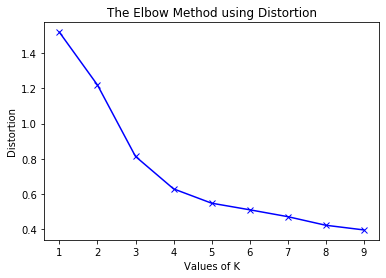

In [34]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

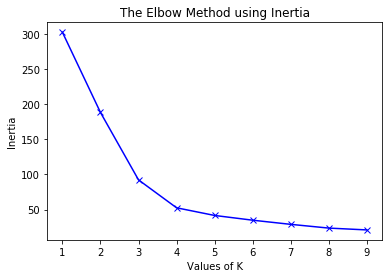

In [35]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [36]:
# run k-mean clustering
k = 4
db = KMeans(n_clusters=k,random_state = 0).fit(res_clustering)

In [40]:
res['Cluster'] = db.labels_ 
res = res.merge(coor, left_on = 'PostalCode', right_on = 'Postal Code', how = 'left')
res = res.drop('Postal Code',1)
res

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown,Cluster,Latitude,Longitude
0,M1B,10,5,0,2,43.806686,-79.194353
1,M1C,3,3,0,2,43.784535,-79.160497
2,M1E,5,4,0,2,43.763573,-79.188711
3,M1G,13,7,0,0,43.770992,-79.216917
4,M1H,14,10,0,0,43.773136,-79.239476
...,...,...,...,...,...,...,...
96,M9N,6,5,0,2,43.706876,-79.518188
97,M9P,5,4,0,2,43.696319,-79.532242
98,M9R,10,6,0,2,43.688905,-79.554724
99,M9V,13,5,0,2,43.739416,-79.588437


### Visualize the clusters

In [41]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(res['Latitude'], res['Longitude'], res['PostalCode'], res['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

## Analyze each cluster

### Cluster 1

In [45]:
res.loc[res['Cluster'] == 0, res.columns[[0]+[1]+[2]+[3]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
3,M1G,13,7,0
4,M1H,14,10,0
7,M1L,10,8,0
16,M2H,14,9,0
17,M2J,13,7,0
18,M2K,14,9,0
19,M2L,11,9,0
21,M2N,11,7,0
22,M2P,13,10,0
23,M2R,15,9,0


### Cluster 2

In [46]:
res.loc[res['Cluster'] == 1, res.columns[[0]+[1]+[2]+[3]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
49,M4W,15,13,1
50,M4X,12,8,1
51,M4Y,10,8,1
52,M5A,9,7,1
53,M5B,12,8,1
54,M5C,13,9,1
55,M5E,10,7,1
56,M5G,12,10,1
57,M5H,12,9,1
58,M5J,6,5,1


### Cluster 3

In [47]:
res.loc[res['Cluster'] == 2, res.columns[[0]+[1]+[2]+[3]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
0,M1B,10,5,0
1,M1C,3,3,0
2,M1E,5,4,0
5,M1J,6,4,0
6,M1K,12,5,0
8,M1M,8,6,0
9,M1N,4,4,0
30,M3L,4,1,0
31,M3M,9,4,0
32,M3N,8,5,0


### Cluster 4

In [48]:
res.loc[res['Cluster'] == 3, res.columns[[0]+[1]+[2]+[3]]]

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
10,M1P,16,14,0
11,M1R,24,15,0
12,M1S,24,13,0
13,M1T,25,16,0
14,M1V,20,11,0
15,M1W,22,11,0
20,M2M,24,11,0
24,M3A,17,12,0
25,M3B,18,12,0
47,M4T,18,10,0


## Recommendation

Zones in __Cluster 2__ locate in downtown, has medium restaurant counts and relatively low restaurant diversity, which means that there's enough traffic in these areas, and opening the kinds of restaurants that have not been covered can be a good business opportunity. 

In [51]:
candidate = res.loc[res['Cluster'] == 1, res.columns[[0]+[1]+[2]+[3]]]
candidate = candidate.sort_values(by = 'Restaurant Counts').reset_index(drop = True)
candidate

,PostalCode,Restaurant Counts,Restaurant Diversity,Downtown
0,M5V,6,6,1
1,M5J,6,5,1
2,M6G,8,7,1
3,M5A,9,7,1
4,M4Y,10,8,1
5,M5E,10,7,1
6,M5T,11,9,1
7,M5S,12,11,1
8,M5K,12,8,1
9,M5H,12,9,1


The top 3 zones, M5V, M5J and M6G are promising zones. Let's check what other venues are there in these zones. 

In [52]:
m5v = venues[venues.PostalCode == 'M5V']
m5v['Venue Category'].value_counts()

Park                     8
Yoga Studio              2
Café                     2
Harbor / Marina          2
Coffee Shop              2
Baseball Stadium         2
Scenic Lookout           2
Gym                      2
Ice Cream Shop           1
Nudist Beach             1
Airport                  1
Hotel                    1
Italian Restaurant       1
Monument / Landmark      1
Trail                    1
Event Space              1
Track                    1
Neighborhood             1
Garden                   1
Skating Rink             1
Dance Studio             1
Dog Run                  1
Restaurant               1
Performing Arts Venue    1
Seafood Restaurant       1
Market                   1
French Restaurant        1
Sandwich Place           1
Aquarium                 1
Music Venue              1
Sculpture Garden         1
Brewery                  1
Lake                     1
Caribbean Restaurant     1
Airport Lounge           1
Ramen Restaurant         1
Name: Venue Category, dtype:

In [53]:
m5j = venues[venues.PostalCode == 'M5J']
m5j['Venue Category'].value_counts()

Coffee Shop                 4
Park                        3
Hotel                       3
Restaurant                  2
Theater                     2
Café                        2
Liquor Store                1
Beer Bar                    1
Yoga Studio                 1
Thai Restaurant             1
Skating Rink                1
Monument / Landmark         1
Japanese Restaurant         1
Ice Cream Shop              1
Pub                         1
Movie Theater               1
Baseball Stadium            1
Event Space                 1
Dessert Shop                1
Comedy Club                 1
Neighborhood                1
Performing Arts Venue       1
Lounge                      1
Concert Hall                1
Scenic Lookout              1
Salad Place                 1
Lake                        1
Brewery                     1
Plaza                       1
Basketball Stadium          1
Roof Deck                   1
Aquarium                    1
Supermarket                 1
Museum    

In [54]:
m6g = venues[venues.PostalCode == 'M6G']
m6g['Venue Category'].value_counts()

Café                             5
Coffee Shop                      4
Grocery Store                    3
Cocktail Bar                     2
Dessert Shop                     2
Korean Restaurant                2
Pizza Place                      2
Arts & Crafts Store              1
Comedy Club                      1
Park                             1
Taco Place                       1
Farmers Market                   1
Health Food Store                1
Ice Cream Shop                   1
School                           1
Middle Eastern Restaurant        1
Pastry Shop                      1
Paper / Office Supplies Store    1
Event Space                      1
Music Store                      1
Bar                              1
Sandwich Place                   1
Spa                              1
Deli / Bodega                    1
Italian Restaurant               1
Playground                       1
Indie Movie Theater              1
Cupcake Shop                     1
Wine Bar            

Looks like they are rather commercial neighborhoods with a lot of parks, shops, food stands, and restaurants, but restaurants can be more diversified. People who wants to seek opportunities in food industry in this neighborhood can try restaurants other than Coffee Shops.